<a href="https://colab.research.google.com/github/Thiraput01/NLP-sys/blob/main/Week%206/2025_hw6_text_classification_student_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 6: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming)

We will focus only on the Object Classification task for this homework.

In this homework, you are asked compare different text classification models in terms of accuracy and inference time.

You will need to build 3 different models.

1. A model based on tf-idf
2. A model based on MUSE
3. A model based on wangchanBERTa

**You will be ask to submit 3 different files (.pdf from .ipynb) that does the 3 different models. Finally, answer the accuracy and runtime numbers in MCV.**

This homework is quite free form, and your answer may vary. We hope that the processing during the course of this assignment will make you think more about the design choices in text classification.

In [1]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv

--2025-02-12 10:32:40--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/8h8hvsw9uj6o0524lfe4i/clean-phone-data-for-students.csv?rlkey=lwv5xbf16jerehnv3lfgq5ue6 [following]
--2025-02-12 10:32:40--  https://www.dropbox.com/scl/fi/8h8hvsw9uj6o0524lfe4i/clean-phone-data-for-students.csv?rlkey=lwv5xbf16jerehnv3lfgq5ue6
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc39c2b51eb5895cda5a859614a0.dl.dropboxusercontent.com/cd/0/inline/Cj84W_re_PH5FoMOcu2s4g0dqAjdn1mxkicNOAkEgXXIf6OyH7pbcOn-gS5hCbhBY6jramAkwRYn0bcQL3G32_vyowy_qyUyBazWIsbIMlqIQVrs2CgSeVXJiJ-9aXJdIps/file# [following]
--2025-02-12 10:32:41--  https://uc39c2b51eb5895cda5a859

In [2]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 17.6 MB/s eta 0:00:00


## Import Libs

In [3]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [4]:
data_df = pd.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [5]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 0.1:
You will have to remove unwanted label duplications as well as duplications in text inputs.
Also, you will have to trim out unwanted whitespaces from the text inputs.
This shouldn't be too hard, as you have already seen it in the demo.



In [6]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [7]:
# TODO.1: Data cleaning

In [8]:
data_df = data_df[['Sentence Utterance', 'Object']]
data_df.columns = ['input', 'label']

In [9]:
data_df.head()

,input,label
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,phone_issues


In [10]:
data_df.label.unique()

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

In [11]:
# Clean label
data_df['label']=data_df['label'].str.lower().copy()

In [12]:
data_df.label.unique()

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [13]:
data_df.duplicated().sum()

2736

In [14]:
# Drop duplicates
data_df = data_df.drop_duplicates("input", keep='first')

In [15]:
data_df.duplicated().sum()

0

In [16]:
# Create label map
label_2_idx = {l:i for i,l in enumerate(data_df.label.unique())}
idx_2_label = {i:l for l,i in label_2_idx.items()}

In [17]:
data = data_df.to_numpy()
data.shape

(13389, 2)

In [18]:
data[:, 1] = np.vectorize(label_2_idx.get)(data[:,1])
data[:, 1]

array([0, 1, 2, ..., 7, 7, 1], dtype=object)

In [19]:
data[:, 0]

array([' <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
       ' internet ยังความเร็วอยุ่เท่าไหร ครับ',
       ' ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', ...,
       'ยอดเงินเหลือเท่าไหร่ค่ะ', 'ยอดเงินในระบบ',
       'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ'], dtype=object)

In [20]:
# Trim
def strip_str(string):
    return string.strip()

data[:, 0] = np.vectorize(strip_str)(data[:,0])
data[:, 0]

array(['<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
       'internet ยังความเร็วอยุ่เท่าไหร ครับ',
       'ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', ...,
       'ยอดเงินเหลือเท่าไหร่ค่ะ', 'ยอดเงินในระบบ',
       'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ'], dtype=object)

# Model 2 MUSE

Build a simple logistic regression model using features from the MUSE model.

Which MUSE model will you use? Why?

**Ans:** *I used cmlm multilingual because it requires low preprocessing with a great performance (I also cannot find dayyass/universal-sentence-encoder-multilingual-large-3-pytorch)*

MUSE is typically used with tensorflow. However, there are some pytorch conversions made by some people.

https://huggingface.co/sentence-transformers/use-cmlm-multilingual
https://huggingface.co/dayyass/universal-sentence-encoder-multilingual-large-3-pytorch

In [21]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [22]:
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

In [23]:
model = SentenceTransformer('sentence-transformers/use-cmlm-multilingual')

sentences = ["This is an example sentence", "Each sentence is converted"]

embeddings = model.encode(sentences)

print(embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Some weights of the model checkpoint at sentence-transformers/use-cmlm-multilingual were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

[[ 0.01540179 -0.02176824 -0.01264852 ...  0.05045104 -0.02573791
   0.01540427]
 [ 0.00617294 -0.01532527 -0.03717831 ...  0.02221826 -0.02915067
  -0.09352501]]


In [24]:
X = data[:, 0]
y = data[:, 1]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train = model.encode(X_train)
X_test = model.encode(X_test)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10711, 768), (2678, 768), (10711,), (2678,))

In [27]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6945481702763256

In [29]:
categories = list(np.unique(data[:, 1]))

Confusion matrix, without normalization
Normalized confusion matrix


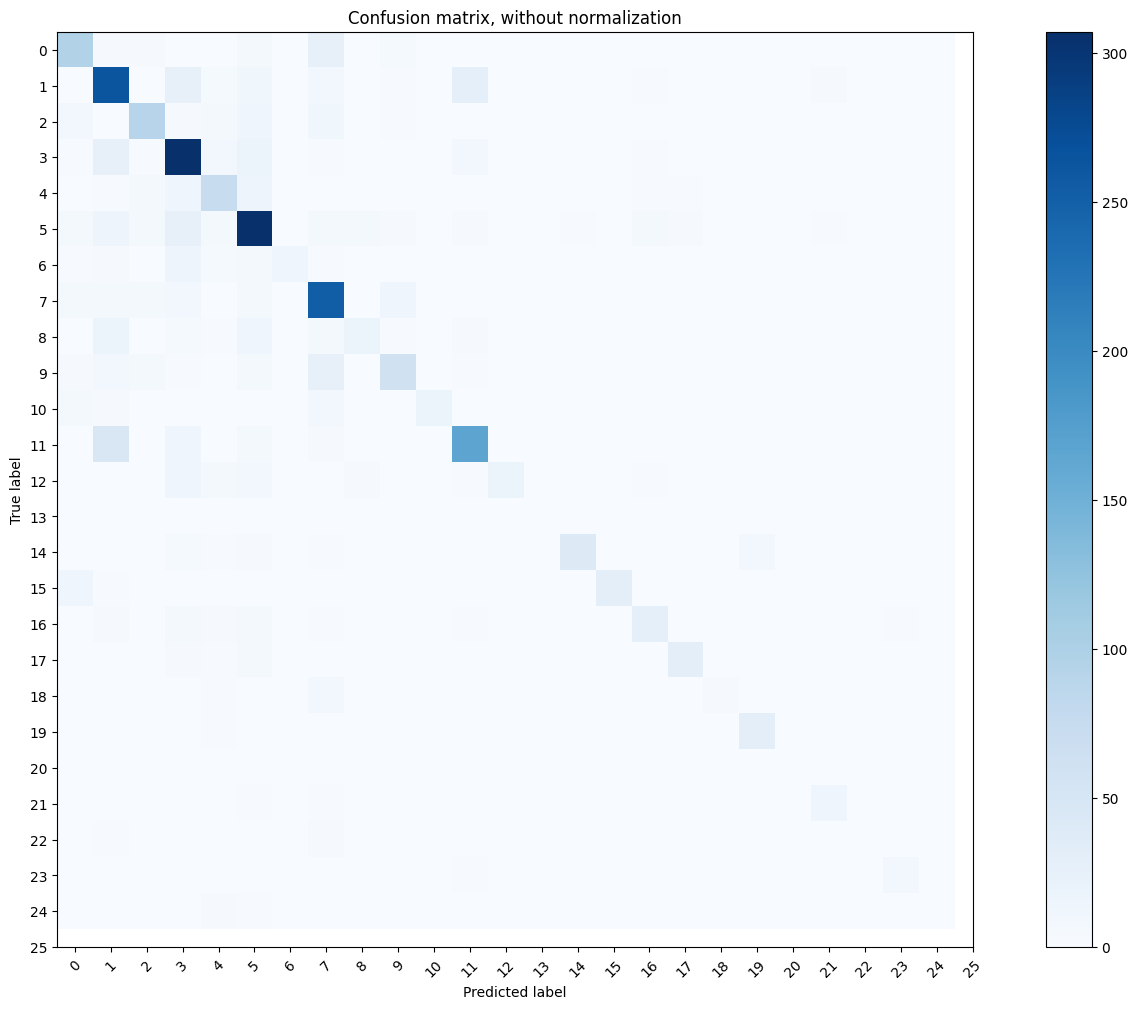

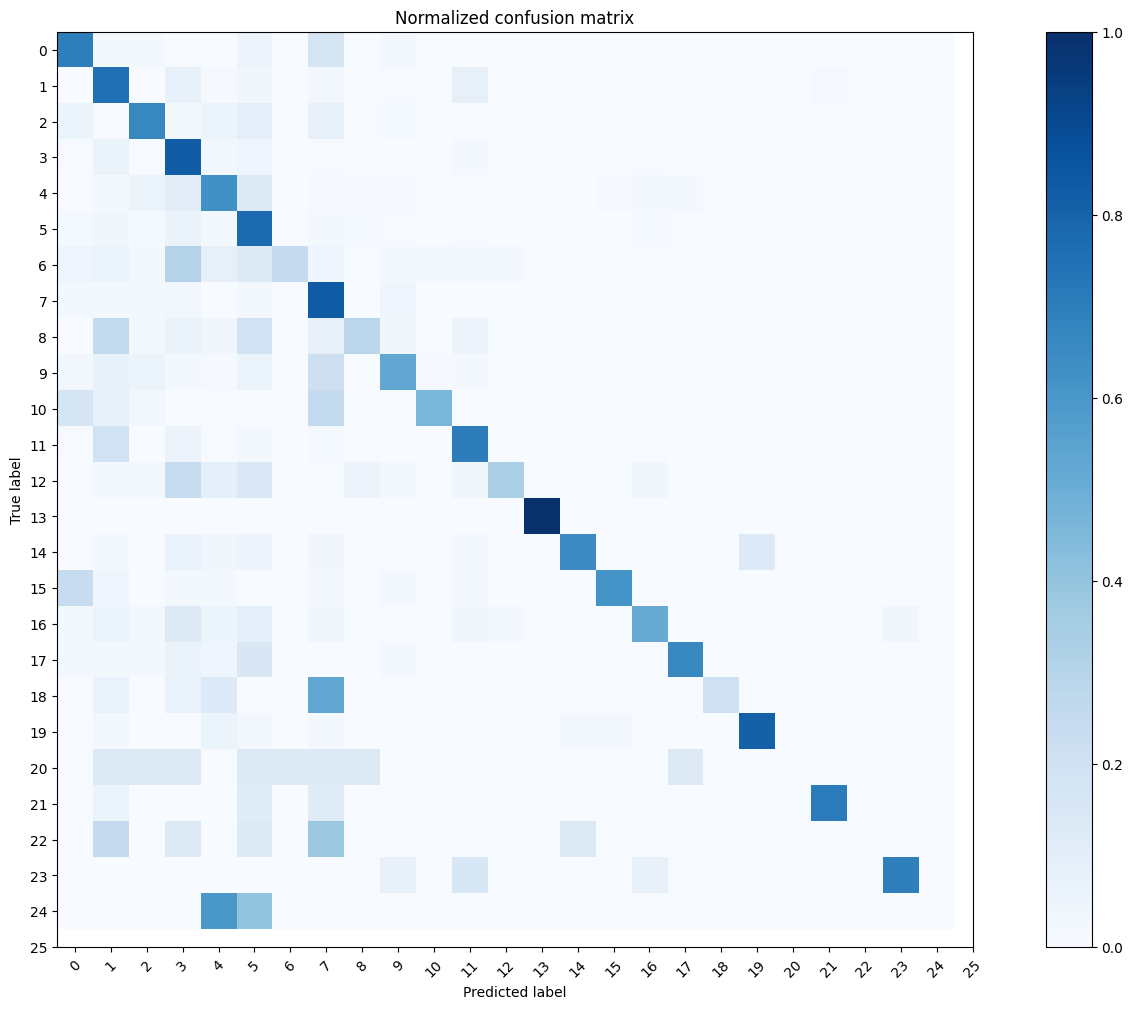

In [30]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=categories,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=categories, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [34]:
from sklearn.metrics import classification_report


unique_classes = np.unique(np.concatenate([y_test, y_pred]))
filtered_categories = [str(cat) for cat in unique_classes]
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=filtered_categories))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68       138
           1       0.65      0.75      0.70       350
           2       0.70      0.66      0.68       136
           3       0.69      0.83      0.75       372
           4       0.57      0.63      0.60       115
           5       0.71      0.77      0.74       396
           6       0.86      0.24      0.38        49
           7       0.68      0.83      0.75       304
           8       0.60      0.29      0.39        63
           9       0.65      0.53      0.59       113
          10       0.84      0.46      0.59        35
          11       0.75      0.70      0.73       237
          12       0.86      0.33      0.48        54
          13       1.00      1.00      1.00         1
          14       0.89      0.65      0.75        60
          15       0.91      0.62      0.74        50
          16       0.65      0.51      0.57        55
          17       0.82    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### calculate time

In [37]:
import time

start_time = time.time()

model = SentenceTransformer('sentence-transformers/use-cmlm-multilingual')



X = data[:, 0]
y = data[:, 1]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

X_train = model.encode(X_train)
X_test = model.encode(X_test)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Time used: ", time.time() - start_time)

Some weights of the model checkpoint at sentence-transformers/use-cmlm-multilingual were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy:  0.6945481702763256
Time used:  36.547412633895874


# Comparison

After you have completed the 3 models, compare the accuracy, ease of implementation, and inference speed (from cleaning, tokenization, till model compute) between the three models in mycourseville.